In [1]:
# ****************************************************************************
#    LOAD data-tables 
# ****************************************************************************
root_path = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo"
CD_samples = pd.read_csv( root_path + "/PyDF_Sample_ClinikData.csv" )
LP_measure = pd.read_csv( root_path + "/PyDF_Lipoproteine.csv")
MB_measure = pd.read_csv( root_path + "/PyDF_Metabolittene.csv")

# Load table with variables and colors
data_type    = "LP"
tableVars_Order_RGB = pd.read_csv(root_path + "/table"+data_type+"_Order_RGB.csv")

vars_order = tableVars_Order_RGB["LP_names"].values.tolist()
vars_color = []
for ii in range(tableVars_Order_RGB.shape[0]):
    vars_color.append([ tableVars_Order_RGB.loc[ii,"R"], 
                        tableVars_Order_RGB.loc[ii,"G"], 
                        tableVars_Order_RGB.loc[ii,"B"] ])

NameError: name 'pd' is not defined

In [567]:
# ----------------------------------------------------------------------------
#  SINGLE TIME POINT - Select samples from the (unique) patients at one time 
#               points. This use the matrix to perform PLS analysis
# ----------------------------------------------------------------------------

import scipy.stats as st
import sys

# Add path to list of known working paths for Python 
sys.path.append('/Users/mattesa/ZenBook/Python/PLS-DA')

import mbc_PLS_basic                # My PLS library
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
import importlib
importlib.reload(mbc_PLS_basic)

# ****************************************************************************
#  - 1 -  PARAMETERS for modelling cross validation
# ****************************************************************************
# Column name for the response variable to use in PLS-DA
unique_PID   = "PatientID"
Response_Col = "Death_Recur_10y"
timepoint    = 5

fold_save    = "Survival"
data_type    = "LP"

# Double cross validation parameters and Fraction test-to-train 
max_N_LV = 10
inner_N_loops = 10;
outer_N_loops = 20;
inner_FractSele = 0.20   
outer_FractSele = 0.20 ; 
# Categories (/level) to use to create two group based on response variable 
min_cat    = 0
max_cat    = 1
# Transform categories into 0 and 1 values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold

             
# ****************************************************************************
#  - 2 -  SELECTION of observation groups for modelling
# ****************************************************************************
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
YY = CD_samples.copy()
# Chose the dataset according to the data_type
if   data_type == "LP":
    dataset = LP_measure               
elif data_type == "MB":
    dataset = MB_measure 
elif data_type == "LP-MB":
    dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)
    
# Select only samples from a specific time point
#mask = YY["Timepoint_kodet"]== 5
#YY = YY.loc[mask]
#dataset = dataset.loc[mask]

# Remove samples with NaN values in Response_Col
mask = YY[Response_Col].isnull().values
YY = YY.loc[ ~mask, : ]
dataset = dataset.loc[ ~mask, : ]

# Display how many sample there are for each category.
col_name = "Status_code"
data_column = YY[Response_Col]
categ = [min_cat, max_cat]
print("Selected groups in ", Response_Col, " are: ")
for cc in categ:
    tot = ( data_column == cc).sum()
    print("Cat. ", cc, " - ",  tot)

# Shuffle the response variable values to test the accuracy of the PLS model
# YY = Shuffle_ColumnValues( YY, Response_Col )

# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 4)
XX = XX.iloc[:,4:]    # XX_vars_scaled
XX, YY = OneWaySele_2Tables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat], transform_cat ) 

Selected groups in  Death_Recur_10y  are: 
Cat.  0  -  804
Cat.  1  -  174


Iteration:   : 20 of 20

Mode num. LV:  1
Accuracy    :  0.81  ( 0.8014, 0.8161 )


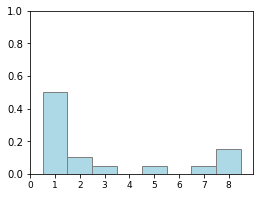

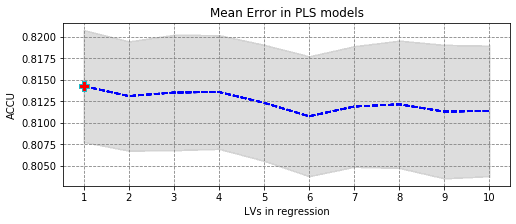

,Mean
Accuracy,0.808772
Specificity,0.996229
Sensitivity,0.006430
Best_nLV,3.750000


In [568]:
# ****************************************************************************
#  - 3 -  PLS Cross-validation of PLS
# ****************************************************************************
PerfoMetric, comparPred, outerCAL, totalCAL, optimal_nLV = optimise_PLS_CrossVal(
                        XX, YY, max_N_LV, unique_PID,
                        Response_Col, min_rval, max_rval, p_threshold , 
                        outer_N_loops, inner_N_loops, outer_FractSele, inner_FractSele,
                        True)
# Calculate the Accuracy CI (confidence intervals)
data  = PerfoMetric.loc["Accuracy"].values.tolist()
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion

# Visualize key results on accuracy and optimal LV number
print("\n")
print("Mode num. LV:  " + str(optimal_nLV) )
PerfoMetric["Mean"] = PerfoMetric.mean(axis=1)
print("Accuracy    :  " + str(round( PerfoMetric.mean(axis=1)["Accuracy"], 2))
                        + "  ( " +str(round(CI[0],4))+", "+str(round(CI[1],4))+ " )" ) 

plot_metrics( outerCAL.T.values , 'ACCU', 'max', True)

pd.DataFrame( PerfoMetric["Mean"] )

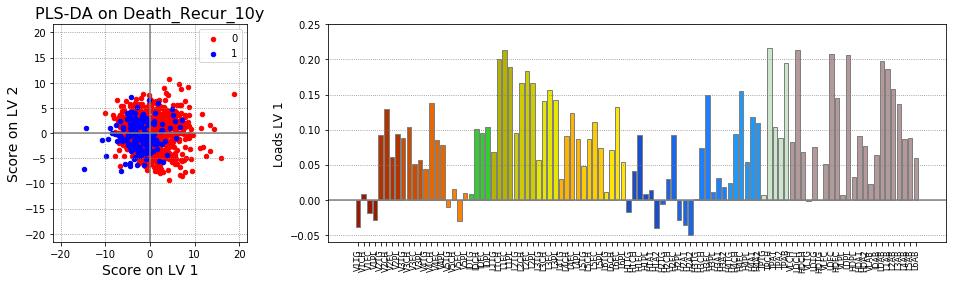

In [573]:
# ****************************************************************************
#  - 4 -  Orthogonal-PLS  and  Plotting
# ****************************************************************************

from pyopls import *
# Create the class OPLS, with the LV to orthogonalize into the first component 
# that was found from perfoming PLS cross validation
opls = OPLS( int(optimal_nLV+1) )
# Fit the model to the data, then get the non-orthogonal components of X 
# i.e. Learn and apply filtering on the training data and get the filtered X, 
# which is called variable Z in the code
Z  = opls.fit_transform( XX, YY[Response_Col])
ZZ_opls = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)

X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( ZZ_opls, YY.loc[:, Response_Col], 8, False)

# --- PLOT
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [5, 16]})

plot_ScoresPLS( X_scores, YY, Response_Col, [min_cat,max_cat] , ax1)

plot_LoadingsPLS( X_loads, YY, Response_Col, [min_cat,max_cat], vars_order, vars_color, 1, ax2)

In [542]:
# ----------------------------------------------------------------------------
#  DELTA_vars - Subtract the measured variables between samples from the same 
#               patients at two time points. This will give us a matrix that
#               measures the change between the two time point
# ----------------------------------------------------------------------------

import scipy.stats as st
import sys

# Add path to list of known working paths for Python 
sys.path.append('/Users/mattesa/ZenBook/Python/PLS-DA')

import mbc_PLS_basic                # My PLS library
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
import importlib
importlib.reload(mbc_PLS_basic)


# ****************************************************************************
#  - 1 -  PARAMETERS for modelling cross validation
# ****************************************************************************
# Column name for the response variable to use in PLS-DA
unique_PID   = "PatientID"
Response_Col = "Death_Recur_10y"
timepoint_A   = 1
timepoint_B   = 5

fold_save    = "Survival"
data_type    = "LP"

# Double cross validation parameters and Fraction test-to-train 
max_N_LV = 10
inner_N_loops = 10;
outer_N_loops = 20;
inner_FractSele = 0.20   
outer_FractSele = 0.20 ; 
# Categories (/level) to use to create two group based on response variable 
min_cat    = 0
max_cat    = 1
# Transform categories into 0 and 1 values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold

             
# ****************************************************************************
#  - 2 -  SELECTION of observation groups for modelling
# ****************************************************************************
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
YY = CD_samples.copy()
# Chose the dataset according to the data_type
if   data_type == "LP":
    dataset = LP_measure               
elif data_type == "MB":
    dataset = MB_measure 
elif data_type == "LP-MB":
    dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)
    
# Select samples from two time point and then calculate the Delta-change
# ----------------------------------------------------------------------------
mask_A = YY["Timepoint_kodet"]== timepoint_A
mask_B = YY["Timepoint_kodet"]== timepoint_B
A_YY = YY.loc[mask_A]
B_YY = YY.loc[mask_B]

# Ensure the two dataframe have the exact patient list. Remove extras from 
# last time point (B) and select only common patients in first timepoint (A)
miss_B_drop = np.setdiff1d( B_YY["PatientID"], A_YY["PatientID"])
miss_A_sele = np.setdiff1d( A_YY["PatientID"], B_YY["PatientID"])
list_nn = np.setdiff1d( A_YY["PatientID"], miss_A_sele )
A_YY = A_YY.loc[A_YY["PatientID"].isin(list_nn)]
B_YY = B_YY.loc[~B_YY["PatientID"].isin(miss_B_drop)]

# Sort-by name columns "Samplename" and then remove uncategorized timepoints.
A_YY = A_YY.sort_values("PatientID")
B_YY = B_YY.sort_values("PatientID")

# Select the XX sub-DF for the two time points 
A_XX = dataset.loc[A_YY.index,:].copy()
B_XX = dataset.loc[B_YY.index,:].copy()
# Calculate the "Delta" between the two time points
DeltaChange = abs(A_XX.iloc[:,4:].values - B_XX.iloc[:,4:].values)
# Create XX (without metadata) and YY to use analysis
XX = pd.DataFrame( DetlaChange, columns=B_XX.iloc[:,4:].columns, index=B_XX.index )
YY = B_YY.copy()
# ----------------------------------------------------------------------------


# Remove samples with NaN values in Response_Col
mask = YY[Response_Col].isnull().values
YY = YY.loc[ ~mask, : ]
XX = XX.loc[ ~mask, : ]

# Display how many sample there are for each category.
col_name = "Status_code"
data_column = YY[Response_Col]
categ = [min_cat, max_cat]
print("Selected groups in ", Response_Col, " are: ")
for cc in categ:
    tot = ( data_column == cc).sum()
    print("Cat. ", cc, " - ",  tot)

# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
# XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 4)

XX, YY = OneWaySele_2Tables( XX, YY, Response_Col, [min_cat,max_cat], transform_cat ) 


Selected groups in  Death_Recur_10y  are: 
Cat.  0  -  105
Cat.  1  -  24


In [574]:
dataset = comparPred["Y_predict"].values
min_cat    = 0
max_cat    = 1
print("Length - ", len(dataset) )


Length -  198


In [585]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(XX, YY[Response_Col]).predict(XX)


In [586]:
y_pred

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,

In [587]:
YY[Response_Col].values

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,